In [1]:
import matplotlib.pyplot as plt
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import pal5_util_old as pal5_util
#from gd1_util import R0, V0
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot


Populating the interactive namespace from numpy and matplotlib


### Gaia

In [2]:
gaia_dat=np.genfromtxt('fromDenis/GD1_stream_track_dens.txt',names=True)

In [3]:
print (gaia_dat.dtype.names)

('phi1mid', 'phi2', 'e_phi2', 'phi2width', 'e_phi2width', 'surf_bright', 'e_surf_bright', 'lindens', 'e_lindens')


In [4]:
midphi1=gaia_dat['phi1mid']
lin_den = gaia_dat['lindens']
elin_den=gaia_dat['e_lindens']
phi2=gaia_dat['phi2']

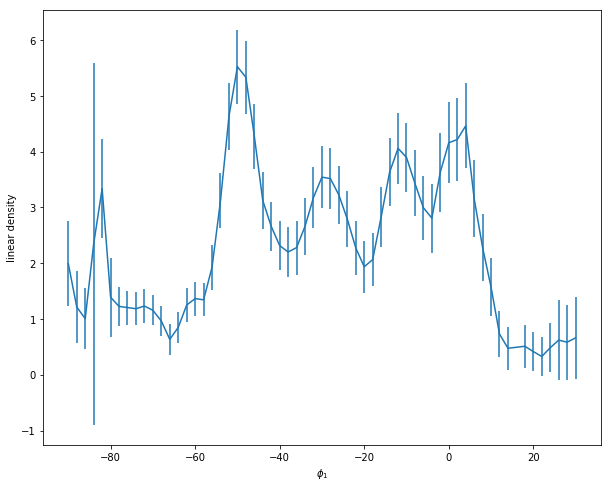

In [5]:

plt.figure(figsize=(10,8))
#plt.plot(phi1,lin_den)
plt.errorbar(midphi1,lin_den,elin_den)
#plt.plot(midphi1)
plt.ylabel(r'linear density')
plt.xlabel(r'$\phi_{1}$')
plt.show()

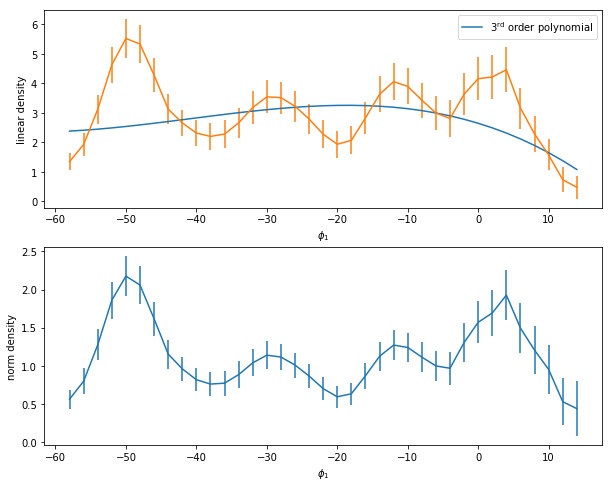

In [6]:
# Apply cuts -60. < phi1 < 15. 

phi1_cut=[]
lin_den_cut=[]
elin_den_cut=[]

for ii in range(len(midphi1)):
    if -60. < midphi1[ii] < 15. :
        phi1_cut.append(midphi1[ii])
        lin_den_cut.append(lin_den[ii])
        elin_den_cut.append(elin_den[ii])

phi1_cut=np.array(phi1_cut)
lin_den_cut=np.array(lin_den_cut)
elin_den_cut=np.array(elin_den_cut)
        
#fit 3rd order polynomial
pp= Polynomial.fit(phi1_cut,lin_den_cut,deg=3,w=1/(elin_den_cut))

norm_den = lin_den_cut/pp(phi1_cut)
norm_den_err = elin_den_cut/pp(phi1_cut)

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(phi1_cut,pp(phi1_cut),label=r'$3^{\rm{rd}}$ order polynomial')
plt.errorbar(phi1_cut,lin_den_cut,elin_den_cut)
#plt.plot(midphi1)
plt.ylabel(r'linear density')
plt.xlabel(r'$\phi_{1}$')
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.errorbar(phi1_cut,norm_den,norm_den_err)
plt.ylabel(r'norm density')
plt.xlabel(r'$\phi_{1}$')
plt.show()


/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()



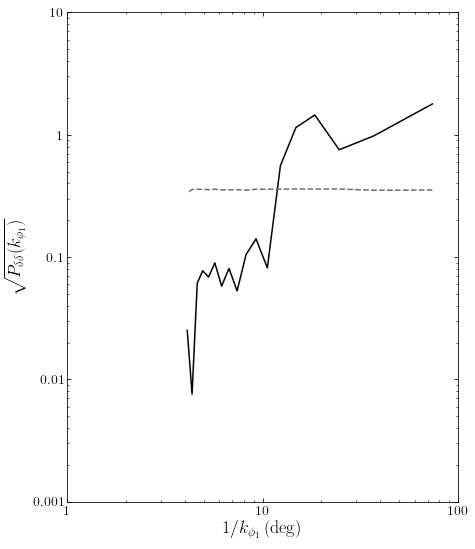

In [8]:
#plot power spectrum

def set_ranges_and_labels_dens():
    
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=18)
    ylim(0.001,10.)
    xlim(1,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None


px,py= signal.csd(norm_den,norm_den,fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',nperseg=len(phi1_cut))
py= py.real
px= 1./px
py= numpy.sqrt(py*(phi1_cut[-1]-phi1_cut[0]))
    
            
# Perform simulations of the noise to determine the power in the noise
nerrsim= 10000
ppy_err= numpy.empty((nerrsim,len(px)))
for ii in range(nerrsim):
    tmock= norm_den_err*numpy.random.normal(size=len(phi1_cut))
    ppy_err[ii]= signal.csd(tmock,tmock,
                            fs=1./(phi1_cut[1]-phi1_cut[0]),scaling='spectrum',
                            nperseg=len(phi1_cut))[1].real
py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(phi1_cut[-1]-phi1_cut[0]))


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,9)

loglog(px,py,color='k',zorder=1)
loglog(px,py_err,color='dimgray',ls='--',zorder=1)
set_ranges_and_labels_dens()
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',fontsize=18)
savefig('plots/GD-1_power_gaia.pdf')

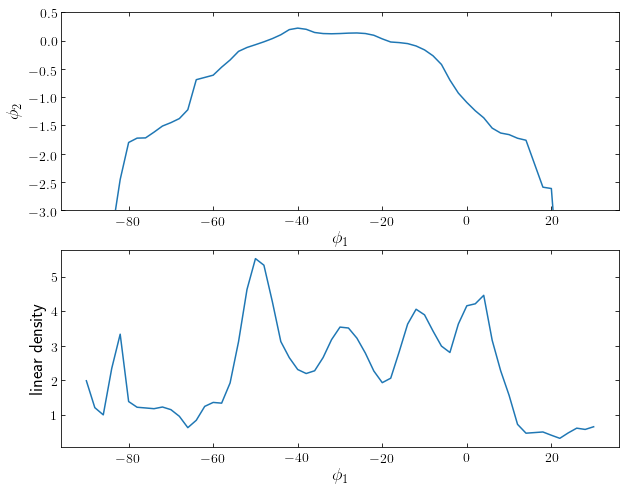

In [10]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
#plt.plot(phi1,lin_den)
plt.plot(midphi1,phi2)

plt.ylabel(r'$\phi_{2}$')
plt.xlabel(r'$\phi_{1}$')
#plt.xlim(-20,20)
plt.ylim(-3,0.5)

plt.subplot(2,1,2)
plt.plot(midphi1,lin_den)
plt.ylabel(r'linear density')
plt.xlabel(r'$\phi_{1}$')
#plt.xlim(-20,20)
plt.show()

### CFHT/Megacam

In [11]:
cfht_dens=np.genfromtxt('fromDenis/cfht_density.txt',names=True)
cfht_track=np.genfromtxt('fromDenis/cfht_track.txt',names=True)
print (cfht_dens.dtype.names, cfht_track.dtype.names)

('phi1', 'surf_bright') ('phi1', 'phi2', 'e_phi2', 'phi2width', 'e_phi2width')


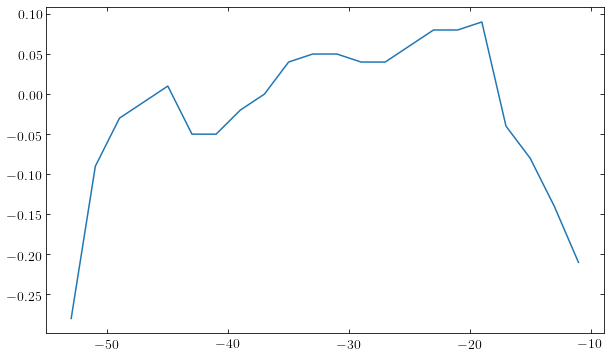

In [13]:
plt.figure(figsize=(10,6))
plt.plot(cfht_track['phi1'],cfht_track['phi2'])
#plt.xlim(-20,20)
plt.show()

### compare surface brightness 

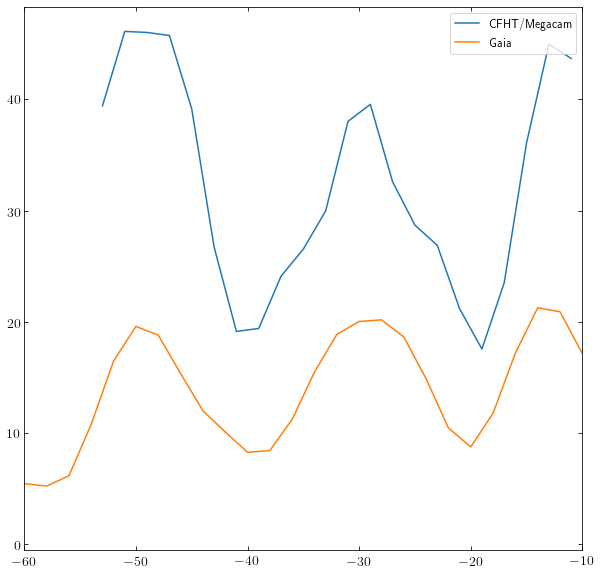

In [14]:
plt.figure(figsize=(10,10))
plt.plot(cfht_dens['phi1'],cfht_dens['surf_bright'],label='CFHT/Megacam')
plt.plot(gaia_dat['phi1mid'],gaia_dat['surf_bright'],label='Gaia')
plt.legend(loc='upper right')
plt.xlim(-60,-10)
plt.show()

